In [2]:
### import libraries
import os
import cv2 as cv2
import numpy as np
import json  as json
import imutils
import math
from matplotlib import pyplot as plt

path_dataset = './dataset/bilboards/'

def iread(img_path, resize_width=None):
    img = cv2.imread(path_dataset + img_path)
    if resize_width is not None:
        img = imutils.resize(img, width=resize_width)
    return img

def iinfo(img):
    print("[IMAGE] height: {} x width: {} x channels: {} - data type: {}".format(
        img.shape[0], 
        img.shape[1], 
        (img.shape[2] if img.ndim > 2 else 0),
        img.dtype))

[IMAGE] height: 1080 x width: 1920 x channels: 0 - data type: uint8
[IMAGE] height: 420 x width: 1920 x channels: 0 - data type: uint8


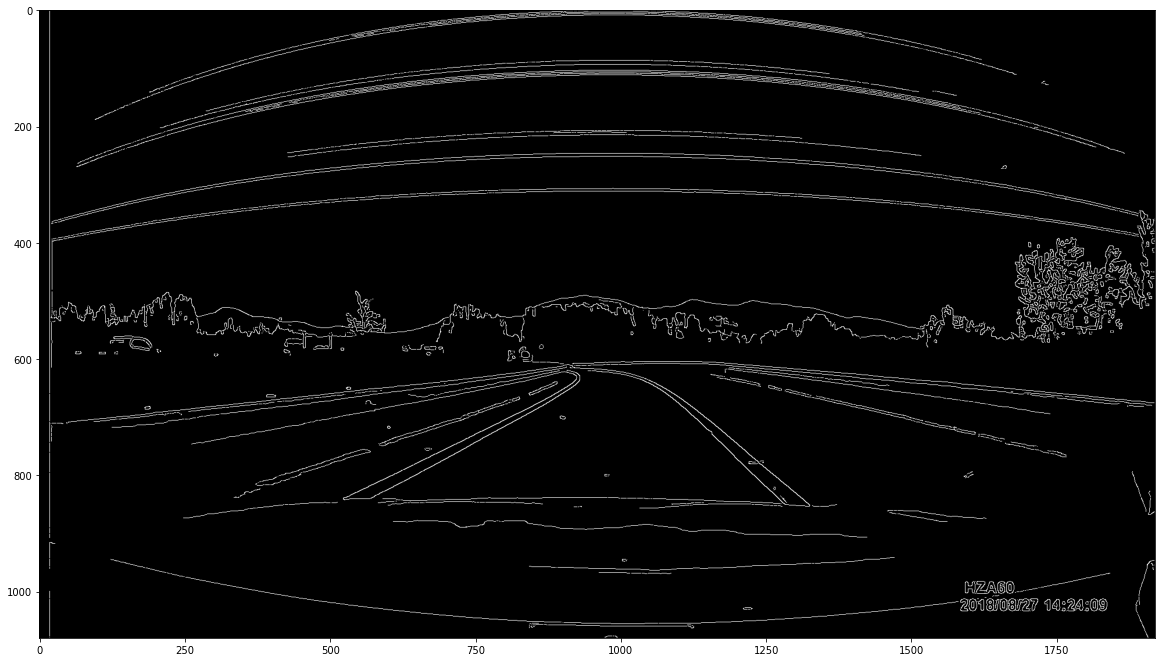

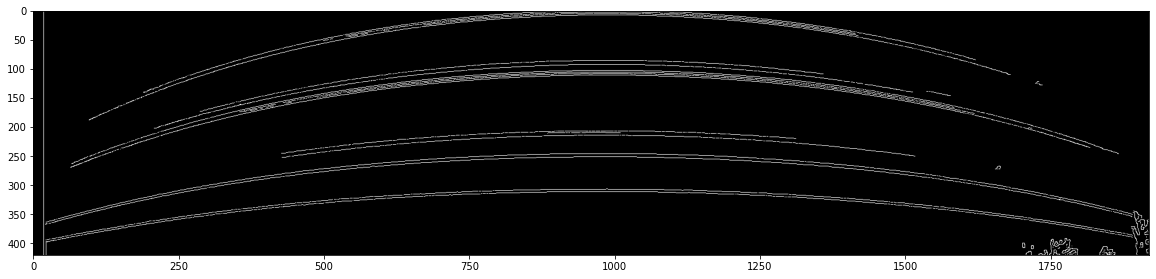

In [3]:
edges_rgb   = iread('dataset_IMG_0249_18_canny.png')
edges_white = cv2.cvtColor(edges_rgb, cv2.COLOR_BGR2GRAY)
edges = cv2.bitwise_not(edges_white)

plt.figure(figsize=(20,20))
plt.imshow(edges, cmap='gray')
iinfo(edges)

roi=edges[0:420, 0:]
plt.figure(figsize=(20, 20))
plt.imshow(roi, cmap='gray')
iinfo(roi)


# Get points

In [4]:
def print_points(pts):
    print("num of points: {}".format(pts.shape))
    plt.figure()
    plt.scatter(pts[:, 0], pts[:, 1])
    plt.gca().invert_yaxis()
    plt.title('Input points')

# Get Minimal Set

In [5]:
def get_minimal_set(pts, number_minimal_pts, debug=False):
    this_pts = pts.copy()
    sample_pts = []
    sample_indices = []
    
    for i in range(number_minimal_pts):
        sample_i = np.random.randint(low=0, high=pts.shape[0] - 1)
        sample_indices.append(sample_i)
        sample_pts.append(this_pts[sample_i])
        this_pts = np.delete(this_pts, sample_i, 0)
    # convert to numpy arrays
    sample_pts     = np.array(sample_pts)
    sample_indices = np.array(sample_indices, dtype=int) 
    
    if debug:
        #print("sample set: \n\t{}\n sample_indices:\n\t {}\n new pts shape: \n\t{}".format(sample_pts, sample_indices, this_pts.shape))
        plt.figure(figsize=(10, 10))
        plt.gca().invert_yaxis()
        x = this_pts[:, 0]
        y = this_pts[:, 1]
        plt.plot(x, y, 'r.')
        
        sample_x = sample_pts[:, 0]
        sample_y = sample_pts[:, 1]
        plt.plot(sample_x, sample_y, 'g.')

    return sample_pts, this_pts, sample_indices

def get_parabola_from_set(coords, debug=False):
    x = coords[:, 0]
    y = coords[:, 1]
    parabola = T.fit(x, y, deg=2, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, parabola(x_axis), 'b')
    return parabola

def get_line_from_set(coords, debug=False):
    x = coords[:, 0]
    y = coords[:, 1]
    
    try:
        line = T.fit(x, y, deg=1, full=False)
    except Exception as e:
        if np.min(x) == np.max(x):
            print ("coords have same x {}".format(coords))
            x = [] + [coords[0][0]] + [coords[0][0] + 0.0001] 
            line = T.fit(x, y, deg=1, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, line(x_axis), 'b')
    return line


# Get Model

In [6]:
import time
from numpy.polynomial import Chebyshev as T

def get_models_lines(pts, number_models, number_minimal_pts=2, debug=False, step_debug=1000, overwrite=False):
    models = list()
    # time utils
    start_time = time.time()
    step_time = time.time()
    
    for j in range(number_models):

        if len(pts) < number_minimal_pts:
            print('pts finished for sampling')
            break
        
        sample_j, new_pts , _   = get_minimal_set(pts, number_minimal_pts=number_minimal_pts, debug=debug)
        line_j            = get_line_from_set(sample_j, debug=debug) 
        models.append(line_j)

        if overwrite:
            pts = new_pts

        # step time end
        if j % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(j, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()    

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Models Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")

    return models
            
            
def get_models_parabola(pts, number_models, number_minimal_pts=2, debug=False, step_debug=1000, overwrite=False):
    models = list()
    # time utils
    start_time = time.time()
    step_time = time.time()
    
    for j in range(number_models):
        if len(pts) < number_minimal_pts:
            print('pts finished for sampling')
            break
        
        sample_j, new_pts , _   = get_minimal_set(pts, number_minimal_pts=number_minimal_pts, debug=debug)
        parabola_j        = get_parabola_from_set(sample_j, debug=debug) 
        models.append(parabola_j)

        if overwrite:
            pts = new_pts

        # step time end
        if j % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(j, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")

    return models    

In [7]:
def print_model(model):
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    plt.plot(x_axis, model(x_axis), 'b')

def print_model_with_pts(model, pts):
    plt.scatter(pts[:, 0], pts[:, 1])
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    plt.plot(x_axis, model(x_axis), 'r')

# Calculate Distance

In [104]:
from numpy import polynomial as P
import cupy as cp

def distance_line_pts(pts, line, thr = roi.shape[0]):
    x = cp.array(pts[:, 0])
    y = cp.array(pts[:, 1])

    try:
        q, m = line.convert(kind=P.Polynomial).coef
    except Exception as e:
        print (e)
        q = line.convert(kind=P.Polynomial).coef
        m = 0
    a = -m
    b = 1
    c = -q
    qs = cp.array(np.repeat(c, len(x)))
    
    d = np.abs((cp.multiply(a, x) + cp.multiply(b, y) + qs) / cp.sqrt(a**2 + b**2))
    d[d>thr] = np.inf
    return d
    

# Preference Matrix


In [10]:
# Preference matrix utils
import seaborn as sn
import time

def print_preference_space(preference_matrix):
    preference_matrix_new = preference_matrix.copy()
    
    preference_matrix_new[preference_matrix==np.inf] = 0
    preference_matrix_new[preference_matrix<np.inf]  = 1
    
    x, y = preference_matrix_new.nonzero()

    plt.figure(figsize=(10, 10))
    plt.gca().invert_yaxis()
    plt.plot(x, y, 'r.')

def print_preference_matrix(matrix):
    fig, ax = plt.subplots(figsize=(15,15))         
    sn.heatmap(matrix, cmap="binary", yticklabels=False)
    #print_preference_space(matrix)

In [105]:
def get_preference_matrix(pts : np.array, models : np.array, thr=roi.shape[0], limit=np.inf, step_debug=50, debug=False):
    
    # time utils
    start_time = time.time()
    
    x = pts[:, 0]
    y = pts[:, 1]
    matrix = cp.array([])
    
    step_time = time.time()
    i = 0
    for m in models:
        if i == limit:
            break
        
        if len(matrix) == 0 :
            matrix = distance_line_pts(pts, m)
        else:
            matrix = cp.column_stack([matrix, distance_line_pts(pts, m)])
        
        # step time end
        if i % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(i, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()
        i += 1
        
    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Preference Matrix Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
#    matrix[matrix > thr] = 0
    return matrix

def print_matrix_info(matrix):
    mean    = matrix[matrix < np.inf].mean()
    minimum = np.min(matrix[matrix < np.inf])
    maximum = np.max(matrix[matrix < np.inf])
    
    num_inf = np.sum((matrix==np.inf).ravel())
    num_min = np.sum((matrix == minimum).ravel())
    num_max = np.sum((matrix == maximum).ravel())
    
    below_avg = np.sum((matrix < mean).ravel())
    above_avg = np.sum((matrix > mean).ravel()) -  num_inf
    
    print("mean:\t {}".format(mean))
    print("min:\t {}".format(minimum))
    print("max:\t {}".format(maximum))
    print("num of total:\t {}".format(matrix.shape[0]))
    print("num of dropped:\t {}".format(num_inf))
    print("num of minimum:\t {}".format(num_min))
    print("num of maximum:\t {}".format(num_max))
    print("num of < average:\t {}".format(below_avg))
    print("num of > average:\t {}".format(above_avg))
    
def print_model_info_matrix(matrix, model_i):
    col = matrix[:, model_i]
    if len(col) == 0:
        print("{} model] pts: 0 num of min: 0, num of max: 0 min: np.inf, max: np.inf".format(model_i))
        return
    num_pts = np.sum((col < np.inf).ravel())

    mean    = col[col < np.inf].mean()
    minimum = np.min(col[col < np.inf])
    maximum = np.max(col[col < np.inf])
    
    num_min = np.sum((col == minimum).ravel())
    num_max = np.sum((col == maximum).ravel())

    print("{} model] pts: {} num of min: {}, num of max: {} min: {}, max: {}".format(model_i, num_pts, num_min, num_max, minimum, maximum))

def model_num_pts(col):
    return np.sum((col < np.inf).ravel())

def model_top_ten(matrix):
    return np.argsort(np.apply_along_axis(model_num_pts, 0, matrix))[::-1][:10]    

# Get Distance Matrix

In [97]:
from scipy.spatial.distance import jaccard, pdist, squareform

def get_distance_matrix(matrix, thr):
    start_time = time.time()
    
    truncated = np.zeros(shape=matrix.shape,dtype=np.uint8)
    truncated[matrix<thr] = 1
    
    # calculate distance between rows
    distance_matrix = pdist(truncated, metric='jaccard')
    distance_matrix = squareform(distance_matrix)

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Distance Matrix Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
    return distance_matrix

def print_distance_matrix(matrix):
    
    # mask because it is simmetrical
    corr = np.corrcoef(np.random.randn(matrix.shape[0], 200))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    
    fig, ax = plt.subplots(figsize=(15,15))
    sn.heatmap(matrix, cmap="binary", mask=mask, vmax=1, vmin=0, xticklabels=False, yticklabels=False)

# Get Distance Clusters

In [95]:
from sklearn.cluster import DBSCAN

def get_clusters_from_distance(distance_matrix, eps, min_samples=5):
    start_time = time.time()

    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(distance_matrix)
    pts_clusters = db.fit_predict(distance_matrix)
    clusters_label = np.unique(pts_clusters)
    
    clusters = {}
    for l in clusters_label:
        clusters.update({l: np.where(pts_clusters == l)[0]})

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Clusters Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")

    return clusters, clusters_label, pts_clusters

def print_cluster(cluster_pts, pts, label, color="b", xlimit=2000, ylimit=400):
    coords = np.take(pts, cluster_pts, axis=0)
    plt.figure(figsize=(10, 10))
    plt.xlim(0, xlimit)
    plt.ylim(ylimit, 0)
    plt.scatter(coords[:, 0], coords[:, 1], 1, c=color)
    plt.title('Cluster {}'.format(label))


In [ ]:
row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points
pts = pts[:5000, :]

# get models
models = get_models_lines(pts, pts.shape[0] * 10, overwrite=True)

# get preference matrix
matrix = get_preference_matrix(pts, models, step_debug=1000, debug=False)

# get distance matrix - threshold = 2
distance_matrix = get_distance_matrix(matrix, 2)

# get output clusters - eps = 0.5
clusters, clusters_label, pts_clusters = get_clusters_from_distance(distance_matrix, 0.5)

0] took: 00 h 00 m 00 s
coords have same x [[ 18  30]
 [ 18 270]]
coords have same x [[1076   10]
 [1076   87]]


/home/fedus/.local/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/home/fedus/.local/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:300: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/home/fedus/.local/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:368: RuntimeWarning: invalid value encountered in add
  return off + scl*x


1000] took: 00 h 00 m 01 s
coords have same x [[ 18 391]
 [ 18 378]]
coords have same x [[880  88]
 [880 108]]
2000] took: 00 h 00 m 00 s
coords have same x [[ 18 419]
 [ 18   8]]
3000] took: 00 h 00 m 00 s
coords have same x [[1106  114]
 [1106   88]]
4000] took: 00 h 00 m 00 s
5000] took: 00 h 00 m 00 s
6000] took: 00 h 00 m 00 s
7000] took: 00 h 00 m 00 s
8000] took: 00 h 00 m 00 s
coords have same x [[712  15]
 [712 317]]
9000] took: 00 h 00 m 00 s
10000] took: 00 h 00 m 00 s
coords have same x [[326 170]
 [326 344]]
11000] took: 00 h 00 m 00 s
pts finished for sampling
Completed! total time: 00 h 00 m 05 s
0] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
1000] took: 00 h 00 m 24 s
not enough values to unpack (expected 2, got 1)
2000] took: 00 h 01 m 01 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
3000] took: 00 

num of points: (5000, 2)


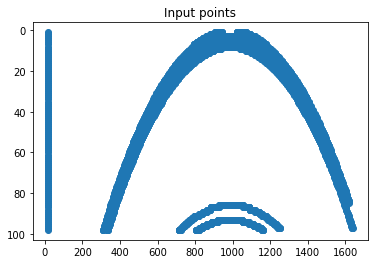

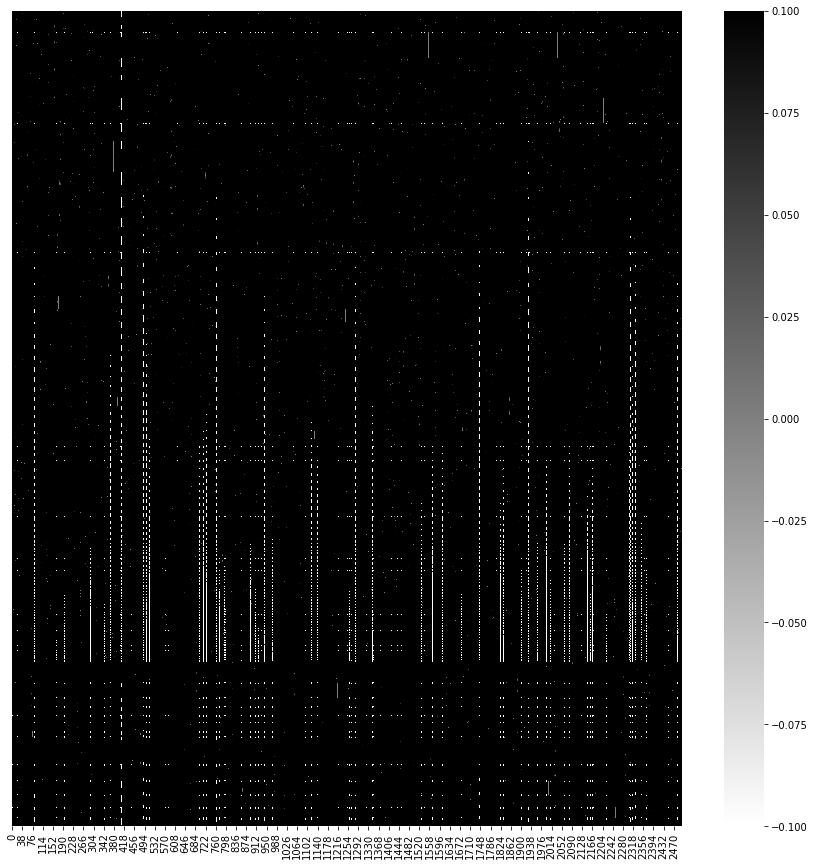

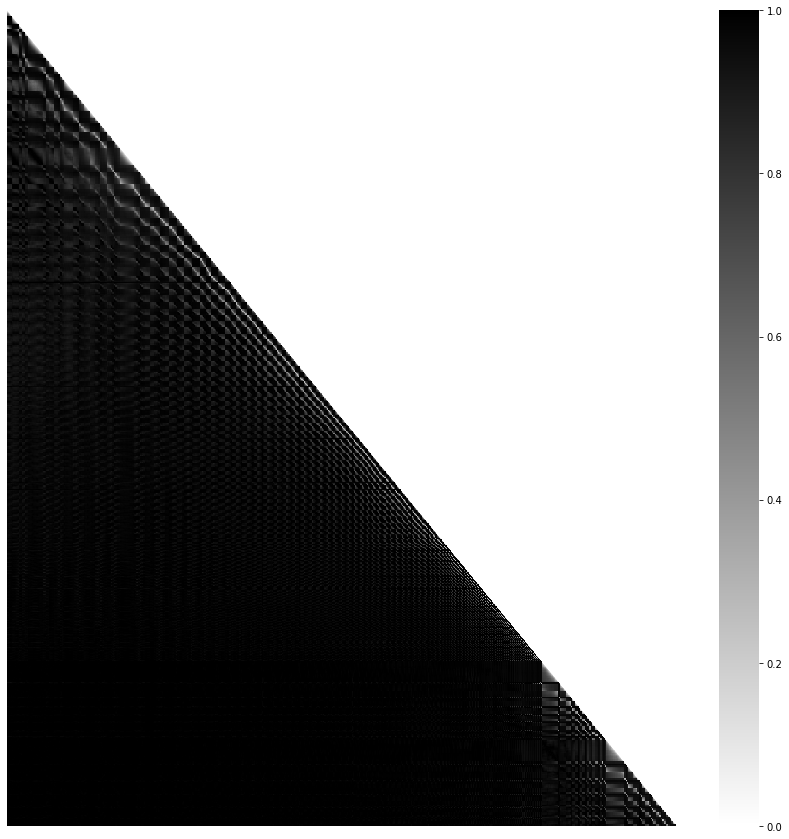

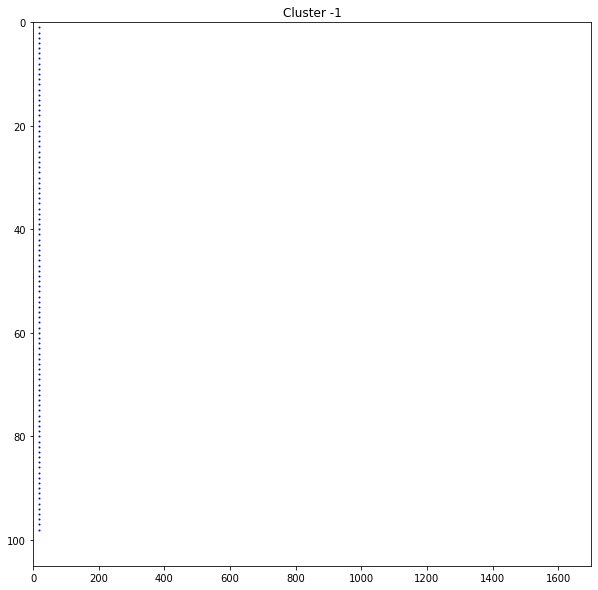

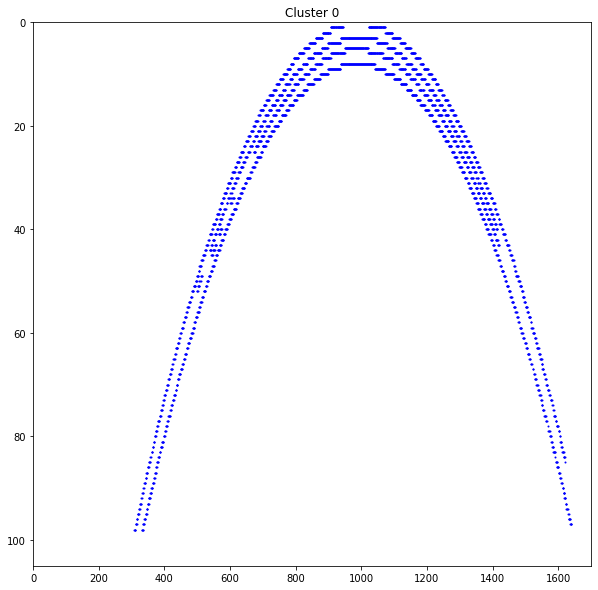

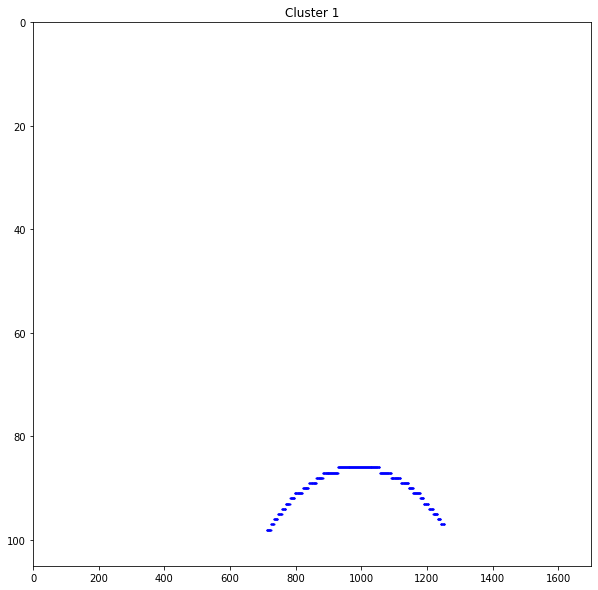

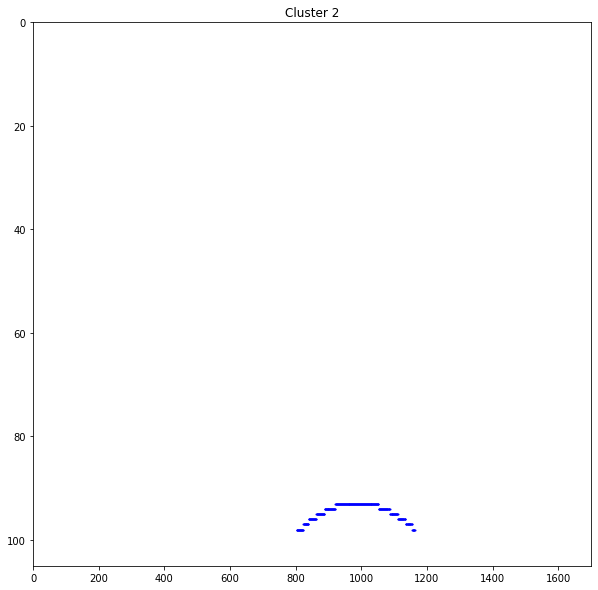

In [20]:
# print points
print_points(pts)

# print preference matrix
print_preference_matrix(matrix)

# print distance matrix
print_distance_matrix(distance_matrix)

# print output clusters
for l in clusters_label:
    print_cluster(clusters[l], pts, '{}'.format(l), xlimit=1700, ylimit=105)

## Rescale

(23003, 2)
1.5 keep] (22381, 2)
2 keep] (12637, 2)
2.5 keep] (8075, 2)
2.75 keep] (6748, 2)
2.9 keep] (6072, 2)
3 keep] (2519, 2)
4 keep] (3139, 2)


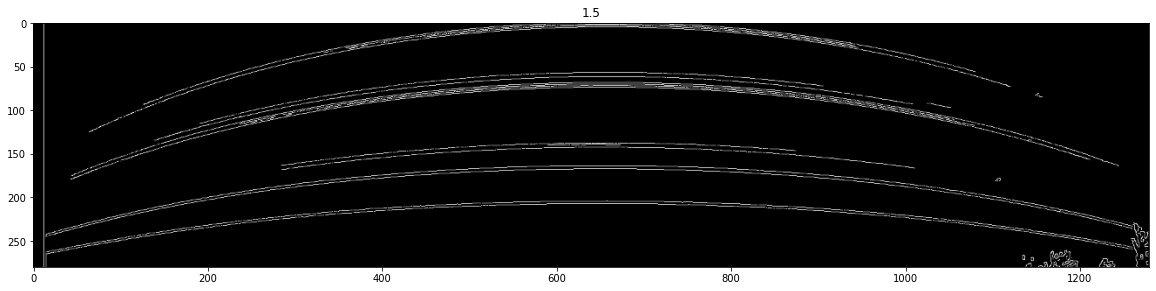

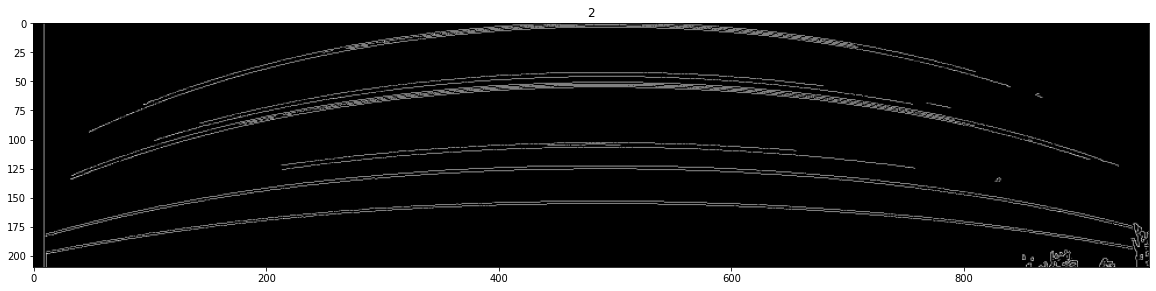

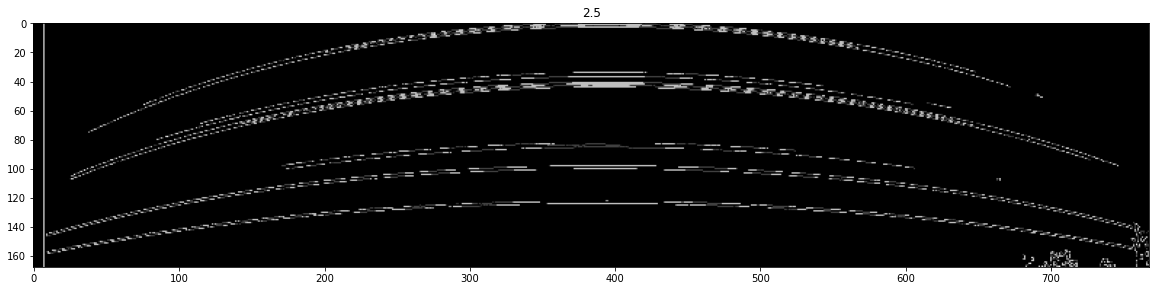

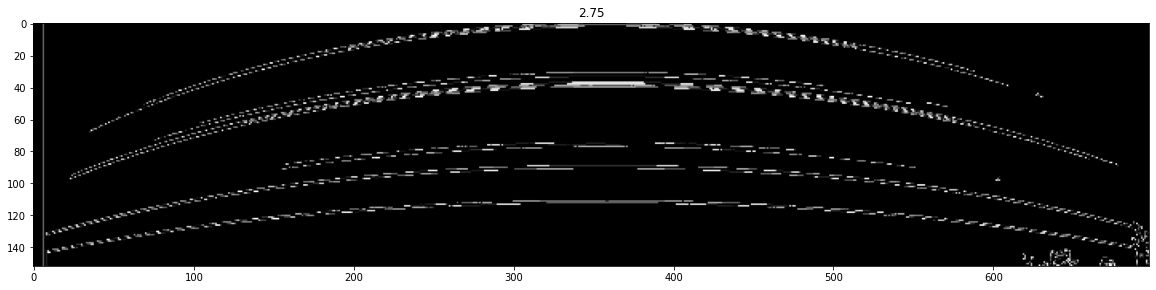

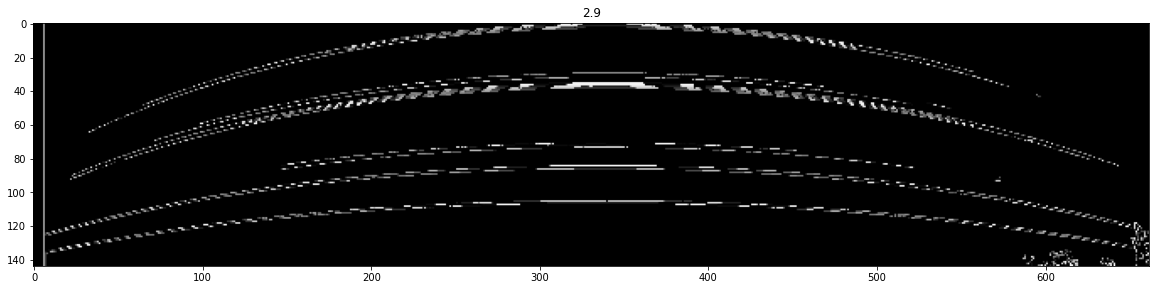

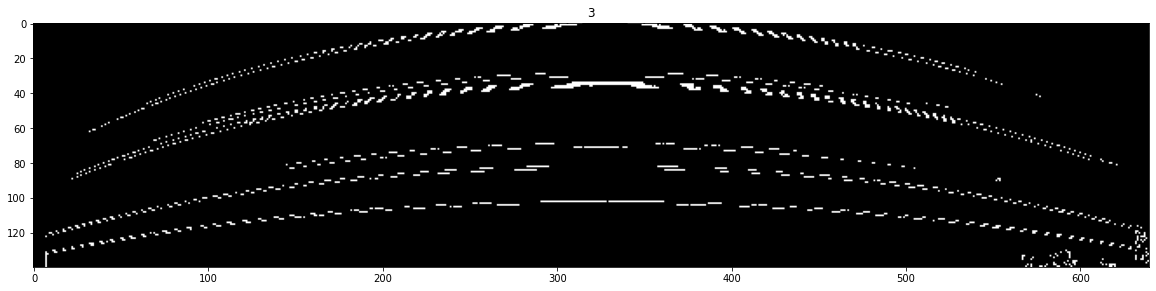

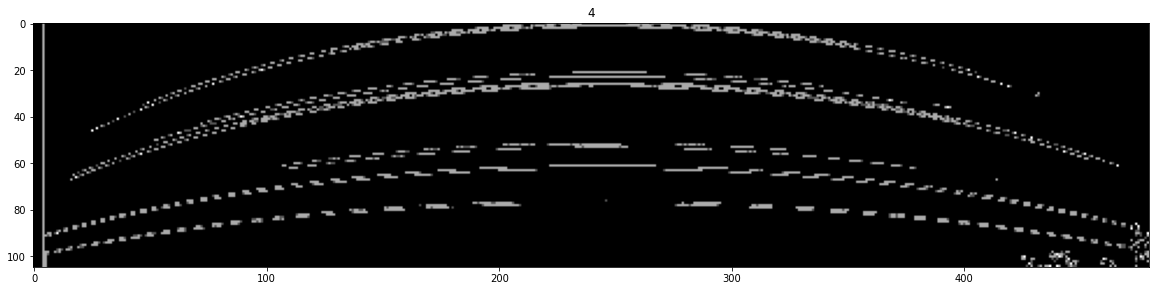

In [50]:
roi=edges[0:420, 0:]

row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points
print(pts.shape)

for factor in (1.5, 2, 2.5, 2.75, 2.9, 3, 4): 
    new_shape = tuple(np.divide(roi.shape, factor).astype(np.int32))[::-1]
    new_roi = cv2.resize(roi, new_shape)

    plt.figure(figsize=(20, 20))
    plt.title('{}'.format(factor))
    plt.imshow(new_roi, cmap='gray')
    new_row, new_col = new_roi.nonzero()
    new_pts = np.column_stack((new_col, new_row)) # this are the points
    print("{} keep] {}".format(factor, new_pts.shape))

In [51]:
roi=edges[0:420, 0:]

#resize
new_shape = tuple(np.divide(roi.shape, 2.9).astype(np.int32))[::-1]
roi = cv2.resize(roi, new_shape)

row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points
#pts = pts[:5000, :]

# get models
models = get_models_lines(pts, pts.shape[0] * 10, overwrite=True)

# get preference matrix
matrix = get_preference_matrix(pts, models, step_debug=1000, debug=False)

# get distance matrix - threshold = 2
distance_matrix = get_distance_matrix(matrix, 2)

# get output clusters - eps = 0.5
clusters, clusters_label, pts_clusters = get_clusters_from_distance(distance_matrix, 0.5)

0] took: 00 h 00 m 00 s
coords have same x [[  6  26]
 [  6 141]]


/home/fedus/.local/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/home/fedus/.local/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:300: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/home/fedus/.local/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:368: RuntimeWarning: invalid value encountered in add
  return off + scl*x


coords have same x [[ 6 86]
 [ 6 20]]
1000] took: 00 h 00 m 00 s
coords have same x [[390   4]
 [390  85]]
coords have same x [[72 72]
 [72 48]]
coords have same x [[455  10]
 [455   9]]
coords have same x [[  6 138]
 [  6  80]]
2000] took: 00 h 00 m 00 s
3000] took: 00 h 00 m 00 s
pts finished for sampling
Models Completed! total time: 00 h 00 m 00 s
0] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
1000] took: 00 h 00 m 06 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
2000] took: 00 h 00 m 17 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2,

In [93]:
roi=edges[0:420, 0:]

#resize
new_shape = tuple(np.divide(roi.shape, 2.9).astype(np.int32))[::-1]
roi = cv2.resize(roi, new_shape)

row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points
#pts = pts[:5000, :]

# get models
models = get_models_lines(pts, pts.shape[0] * 10, overwrite=True)

# get preference matrix
matrix = get_preference_matrix(pts, models, step_debug=1000, debug=False)

# get distance matrix - threshold = 2
distance_matrix = get_distance_matrix(matrix, 2)

# get output clusters - eps = 0.5
clusters, clusters_label, pts_clusters = get_clusters_from_distance(distance_matrix, 0.5)

0] took: 00 h 00 m 00 s
coords have same x [[ 6 28]
 [ 6 44]]
coords have same x [[605  71]
 [605 142]]
coords have same x [[306  86]
 [306 105]]
1000] took: 00 h 00 m 00 s
coords have same x [[237 109]
 [237  41]]
coords have same x [[  6  18]
 [  6 100]]
2000] took: 00 h 00 m 00 s
3000] took: 00 h 00 m 00 s
pts finished for sampling
Models Completed! total time: 00 h 00 m 00 s
0] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
1000] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
2000] took: 00 h 00 m 01 s
not enough v

NameError: name 'get_distance_matrix' is not defined

num of points: (6072, 2)
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


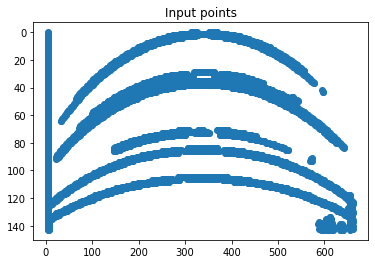

In [15]:
# print points
print_points(pts)

# print preference matrix
#print_preference_matrix(matrix)

# print distance matrix
#print_distance_matrix(distance_matrix)

# print output clusters
print(clusters_label)
#for l in clusters_label:
#    print_cluster(clusters[l], pts, '{}'.format(l), xlimit=roi.shape[1], ylimit=roi.shape[0])

In [98]:
distance_matrix = get_distance_matrix(matrix, 2.5)

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [121]:
clusters, clusters_label, pts_clusters = get_clusters_from_distance(distance_matrix, 0.75, min_samples=8)
print(clusters_label)

Clusters Completed! total time: 00 h 00 m 00 s
[-1  0  1  2  3]


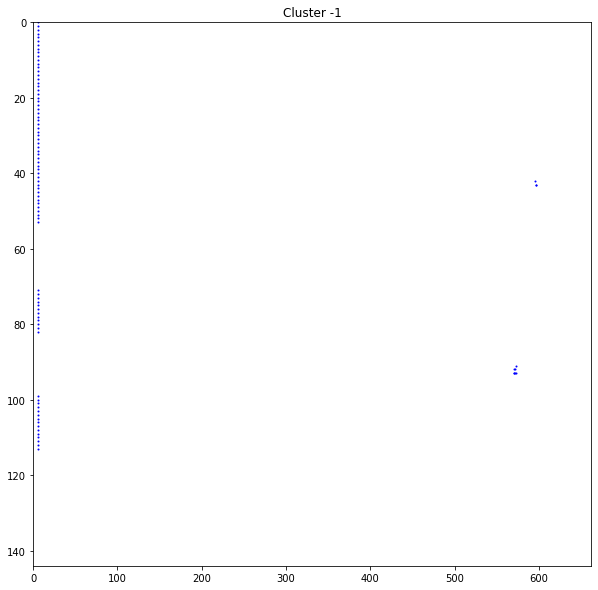

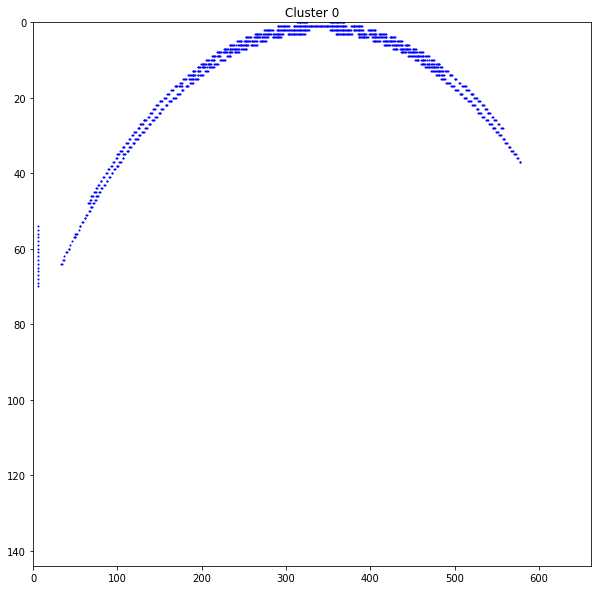

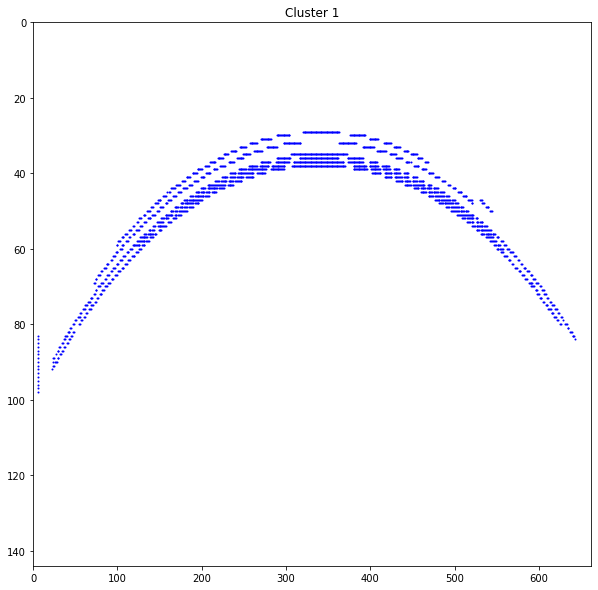

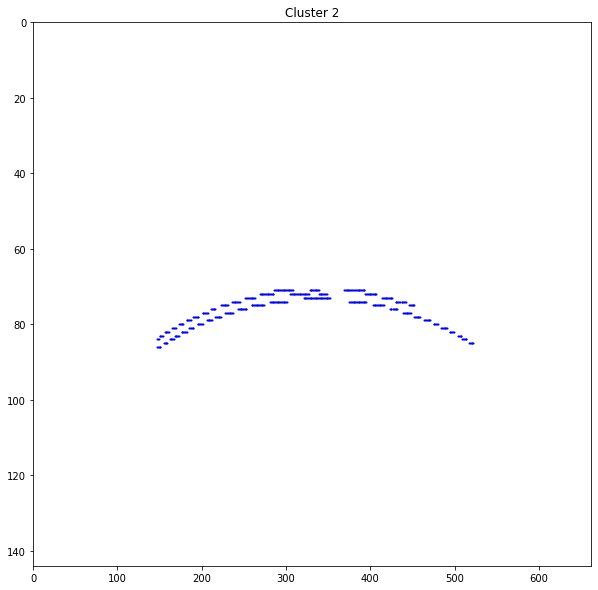

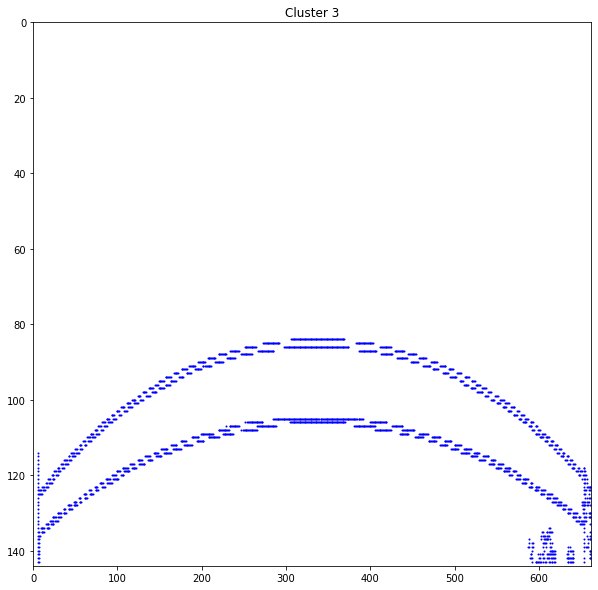

In [122]:
# print output clusters
for l in clusters_label:
    print_cluster(clusters[l], pts, '{}'.format(l), xlimit=roi.shape[1], ylimit=roi.shape[0])

In [106]:
roi=edges[0:420, 0:]

#resize
new_shape = tuple(np.divide(roi.shape, 2.9).astype(np.int32))[::-1]
roi = cv2.resize(roi, new_shape)

row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points
#pts = pts[:5000, :]

# get models
models = get_models_lines(pts, pts.shape[0] * 10, overwrite=True)

# get preference matrix
matrix = get_preference_matrix(pts, models, step_debug=1000, debug=False)
matrix = cp.asnumpy(matrix)

distance_matrix = get_distance_matrix(matrix, 2.5)

0] took: 00 h 00 m 00 s
coords have same x [[325  72]
 [325  86]]


/home/ubuntu/.local/lib/python3.8/site-packages/numpy/polynomial/polyutils.py:345: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/polynomial/polyutils.py:346: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/polynomial/polyutils.py:414: RuntimeWarning: invalid value encountered in add
  return off + scl*x


1000] took: 00 h 00 m 00 s
2000] took: 00 h 00 m 00 s
coords have same x [[332  86]
 [332   1]]
coords have same x [[488  47]
 [488  81]]
3000] took: 00 h 00 m 00 s
pts finished for sampling
Models Completed! total time: 00 h 00 m 00 s
0] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
1000] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
2000] took: 00 h 00 m 01 s
not enough val

In [19]:
x = cp.array(pts[:, 0])
y = cp.array(pts[:, 1])


In [82]:
m = matrix.copy()
x1 = m[1, :]
x2 = m[2, :]

print(x1)
print(x2)
def truncate(x, thr):
    new_x = x.copy().astype(np.int32)
    new_x[x<=thr] = 1
    new_x[x>thr]  = 0
    return new_x

x1 = truncate(x1, 40)
x2 = truncate(x2, 40)
print(x1)
print(x2)

from scipy.spatial.distance import jaccard

jaccard(cp.asnumpy(x1), cp.asnumpy(x2))



[ 21.77665677  39.         110.84108989 ... 104.42704105 106.42059855
          inf]
[ 21.35246713  39.         110.8872833  ... 104.44260337 106.39358139
          inf]
[1 1 0 ... 0 0 0]
[1 1 0 ... 0 0 0]


0.008028545941123996

In [92]:
1-cp.sum(cp.bitwise_and(x1, x2)) / (cp.bitwise_or(x1, x2)).sum()

array(0.00802855)

In [88]:
cp.bitwise_and(x1, x2).sum()

array(1112)

In [89]:
cp.bitwise_or(x1, x2)

array([1, 1, 0, ..., 0, 0, 0], dtype=int32)